# Labelling data with LLMs

In [1]:
from openai import OpenAI
import requests
from bs4 import BeautifulSoup
import html2text as h2t
from urllib.parse import urljoin, urlparse
from datetime import datetime
from pathlib import Path
import pandas as pd
from glob import glob
import numpy as np
import re
import matplotlib.pyplot as pl

from xavy.dataframes import bold
import xavy.explore as xe
import xavy.dataframes as xd

In [2]:
# For RAG:
import llama_index.llms.openai as lio
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, get_response_synthesizer
from llama_index.core.vector_stores import ExactMatchFilter, MetadataFilters
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.readers.file import MarkdownReader
from llama_index.core import StorageContext, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

## Functions

In [3]:
def load_env_vars(filename):
    """
    Loads environment variables from path `filename` into a dict.

    Lines starting with '#' are ignored. Variables settings must
    happen one per line and follow the pattern 
    '<variable_name>=<variable_value>'.
    """

    # Read the file:
    with open(filename, 'r') as f:
        env_content = f.read()
    # Split the lines:
    lines = env_content.split('\n')
    # Select lines containing variables:
    variables = list(filter(lambda s: len(s) > 0 and s.find('=') !=-1 and s[0] != '#', lines))
    # Parse the variables into a dict:
    env_vars = {v.split('=')[0]:v.split('=')[1] for v in variables}

    return env_vars 


def http_get(url, max_retries=3, timeout=10):
    """
    Make an HTTP GET request to `url` (str) and return a response object.

    Parameters
    ----------
    url : str
        The Web Address to request.
    max_retries : int
        Maximum number of request trials before giving up.
    timeout : float
        How long to wait for a response, in seconds.
    """
    # Prepare for request:
    session = requests.session()
    session.mount('http://', requests.adapters.HTTPAdapter(max_retries=max_retries))
    
    # GET:
    ssl_verify = True
    try:
        response = session.get(url, timeout=timeout)
    # In case of SSL Certificate error:
    except requests.exceptions.SSLError:
        ssl_verify = False
        response = session.get(url, timeout=timeout, verify=ssl_verify)

    # If forbidden, try pretending to be a browser:
    if response.status_code in {403, 404, 406, 412, 503, 429}:
        browser_header = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:136.0) Gecko/20100101 Firefox/136.0'}
        response = session.get(url, timeout=timeout, headers=browser_header, verify=ssl_verify)
    
    # If fail:
    if response.status_code != 200:
        raise Exception('HTTP request failed with code ' + str(response.status_code))
    
    return response


def remove_invis_tags(soup, tag_types=['script', 'style', 'noscript', 'area', 'iframe', 'base', 'embed', 'input', 'link', 'meta', 'source', 'track', 'video', 'head', 'title', 'object', 'select', 'option']):
    """
    Remove tags from BeautifulSoup object `soup` that do 
    not contain text to be rendered in the browser. All
    tags in `tag_types` will be removed. Transformation
    is performed in place.
    """
    
    # Select body:
    body = soup.find('body')
    
    # Remove tags:
    for tag in tag_types:
        tags = body.find_all(tag)
        for t in tags:
            t.decompose()
    
    return body


def replace_images_with_alt(soup):
    """
    Replaces all <img> tags in the HTML with their alt text.
    
        soup : BeautifulSoup object
            The original HTML content.
        
    """    
    for img in soup.find_all('img'):
        alt_text = img.get('alt', 'IMAGE') 
        if len(alt_text.strip()) == 0:
            alt_text = 'IMAGE'
        img.replace_with(alt_text)
    
    return soup


def relative2urls(soup, base_url):
    """
    Make relative hyperlinks into full URLs.
    Take a `soup` (Beautiful soup object) and the `base_url` (str) 
    from which the webpage was GET from. 
    """
    
    for anchor in soup.find_all('a'):
        if 'href' in anchor.attrs:
            anchor['href'] = urljoin(base_url, anchor['href'])
    
    return soup
    

def html2md(html, ignore_links=False):
    """
    Transform the `html` code (str) into markdown.
    If `ignore_links` is True, do not show links in
    the markdown.
    """
    h = h2t.HTML2Text()
    h.ignore_links = ignore_links
    markdown = h.handle(html)
    return markdown


def get_web_content(url):
    """
    Get text content from an `url` and output as a BeautifulSoup object.
    """
    
    # Get content:
    response = http_get(url, timeout=50)
    
    # Remove unnecessary HTML code:
    soup = BeautifulSoup(response.content.decode('utf-8'))
    body = remove_invis_tags(soup)
    # Replace images with text:
    body = replace_images_with_alt(body)
    # Make links complete URLs:
    body = relative2urls(body, url)

    return body
    

def soup2markdown(soup, ignore_links=False):
    """
    Transforms a BeautifulSoup object (HTML) into markdown.
    If `ignore_links` is True, do not show links in the markdown.
    """
    
    # Transform HTML into markdown:    
    markdown = html2md(soup.prettify(), ignore_links=ignore_links)
    #markdown = html2md(str(soup), ignore_links=ignore_links)

    return markdown


def make_filename(url, ignore_links=None):
    """
    Create '.md' filename from URL using domain as identifier
    and adding tags for `ignore_links` and current date.
    Returns a string.
    """

    # Get domain:
    filename = urlparse(url)
    filename = filename.netloc.replace('.', '-')
    # Hyperlinks tag:
    if ignore_links == True:
        filename += '_nolinks'
    elif ignore_links == False:
        filename += '_wlinks'
    # Add date:
    filename += datetime.now().strftime('_%Y-%m-%d')
    # Add extension:
    filename += '.md'

    return filename


def save_text(dir_path, filename, text):
    """
    Save `text` (str) to a file named `filename` (str) 
    in `dir_path` folder (str).
    """
    path = Path(dir_path) / Path(filename)
    with open(path, 'w') as f:
        f.write(text)


def read_text(path):
    """
    Read text from file at `path` (str).
    Returns a str.
    """
    with open(path, 'r') as f:
        text = f.read()
    return text
    

def filename2metadata(path, df):
    """
    Given a filename `path` containing information about the 
    associated markdown, extract: the domain; if there 
    are links in the markdown or not; and the capture
    date. These informations must be present in filename 
    in the following pattern:

    {www-info-toshiba-com}_{linksornot}_{%Y-%m-%d}.md

    `df` is a lookup table from 'filename_prefix' to 'website'.
    """
    
    # Parse information:
    filename = path.split('/')[-1]
    parts = filename.split('.')[0].split('_')
    prefix = parts[0]
    mdtype = parts[1]
    date   = parts[2]

    # Lookup domain:
    domains = df.loc[df['filename_prefix'] == prefix, 'website']
    assert len(domains) == 1, 'Should have found one entry for {:}, but found {:}'.format(prefix, len(domains))
    domain = urlparse(domains.iloc[0]).netloc

    # Set dict:
    metadata = {'prefix': prefix, 'domain': domain, 'mdtype': mdtype, 'date': date}

    return metadata
    

def sel_chunks_by_domain(documents, domain, ignore_links=None):
    """
    Filter a list of Llama index documents by metadata.

    Parameters
    ----------
    documents : list
        List of documents to filter
    domain : str
        Domain of the website content to be selected.
    ignore_links : Bool or None
        If True, select documents without links. If False,
        select documents with links. If None, select all.

    Returns
    -------
    domain_docs : list
        List of documents from the specified domain and 
        document type (with links or not).
    """
    
    # Select chunks about a specific domain:
    domain_docs = list(filter(lambda x: x.metadata['domain'] == domain, documents))

    # Select with or without hyperlinks (if requested):
    if ignore_links in {True, False}:
        link_flag = 'nolinks' if ignore_links else 'wlinks'
        domain_docs = list(filter(lambda x: x.metadata['mdtype'] == link_flag, domain_docs))

    return domain_docs


def build_query_engine(index, domain, ignore_links, env, similarity_top_k=2, model='gpt-4o-mini', temperature=0.1, response_mode="compact"):
    """
    Return a query engine for documents from a given domain and markdown 
    type by pre-filtering the documents accordingly.

    Parameters
    ----------
    index : VectorStoreIndex
        The semantic vector index of the documents.
    domain : str
        The domain for which to search for, specified in the documents 
        metadata.
    ignore_links : bool
        Whether to search in documents without links (True) or 
        containing links (False).
    env : dict
        OpenAI API environmnent variables, including:
        OPENAI_API_KEY and OPENAI_PROJECT_ID.
    similarity_top_k : int
        Number of top k results from the retriever to return.
    model : str
        OpenAI llm model to use to synthesize the response.
    temperature : float
        Response synthesizer temperature, from 0 (deterministic) to 
        1 (random).
    response_mode : str
        How to apply the LLM to the retrieved documents.

    Returns
    -------
    query_engine : RetrieverQueryEngine
        A Query engine that can be used by calling:
        `query_engine.query('What is this domain?')`
    """
    
    # Make retriever from chunks from a specific domain and document type (w/ or wo/ links):
    if ignore_links in {True, False}:
        link_flag = 'nolinks' if ignore_links else 'wlinks'
    else:
        raise Exception('Unknown `ignore_links` "{}".'.format(ignore_links))
    retriever = index.as_retriever(filters=MetadataFilters(filters=[ExactMatchFilter(key='domain', value=domain), ExactMatchFilter(key='mdtype', value=link_flag)]),
                                   similarity_top_k=similarity_top_k)
    
    # Set LLM to use to create response:
    openai_llm = lio.OpenAI(model=model, api_key=env['OPENAI_API_KEY'], project=env['OPENAI_PROJECT_ID'], temperature=temperature)
    synthetizer = get_response_synthesizer(llm=openai_llm, response_mode=response_mode)
    
    # Build query:
    query_engine = RetrieverQueryEngine(retriever=retriever, response_synthesizer=synthetizer)

    return query_engine


def build_retriever(index, domain, ignore_links=True, similarity_top_k=2):
    """
    Return a retriever for documents from a given domain and markdown 
    type by pre-filtering the documents accordingly.

    Parameters
    ----------
    index : VectorStoreIndex
        The semantic vector index of the documents.
    domain : str
        The domain for which to search for, specified in the documents 
        metadata.
    ignore_links : bool
        Whether to search in documents without links (True) or 
        containing links (False).
    similarity_top_k : int
        Number of top k results from the retriever to return.

    Returns
    -------
    retriever : VectorIndexRetriever
        A retriever that can be used by calling:
        `retriever.retrieve('Kind of organization')`
        Only documents from the specified domain and markdown
        types are used.
    """
    
    # Make retriever from chunks from a specific domain and document type (w/ or wo/ links):
    if ignore_links in {True, False}:
        link_flag = 'nolinks' if ignore_links else 'wlinks'
    else:
        raise Exception('Unknown `ignore_links` "{}".'.format(ignore_links))
        
    retriever = index.as_retriever(filters=MetadataFilters(filters=[ExactMatchFilter(key='domain', value=domain), ExactMatchFilter(key='mdtype', value=link_flag)]),
                                   similarity_top_k=similarity_top_k)
    return retriever


def load_assoc_md(org, folder='../data/processed/org_websites/'):
    """
    Load the organization's website in markdown format
    from a local file.

    Parameters
    ----------
    org : Series or dict
        Information about the organization. The required 
        fields are: 'filename_prefix', 'name' and 'website'.
    folder : str
        Path to the folder containing the website mardowns.

    Returns
    -------
    site_md : str
        Website content, formatted as markdown.
    """
    
    # Search for files:
    prefix = org['filename_prefix']
    site_files = glob(folder + '{}_wlinks_*.md'.format(prefix))
    assert len(site_files) <= 1, 'Found more that one file for website {}'.format(org['website'])

    # Error message: if no file is found.
    if len(site_files) < 1:
        print('* {:} ({:}): No website.'.format(org['name'], org['website']))
        return None
        
    # Get landing page content in markdown format:
    site_md = read_text(site_files[0]).strip()
    
    # Error message: empty website
    if len(site_md) == 0:
        print('* {:} ({:}): No text captured from website.'.format(org['name'], org['website']))

    return site_md
    

def find_about_link(org, folder='../data/processed/org_websites/', verbose=False):
    """
    Find a hyperlink to an about page on the organization's website
    (previously downloaded and formatted as markdown).

    Parameters
    ----------
    org : Series or dict
        Information about the organization. The required 
        fields are: 'filename_prefix', 'name' and 'website'.
    folder : str
        Path to the folder containing the website mardowns.

    Returns
    -------
    link : str or None
        Hyperlink to a (likely) webpage about the organization.
        Return None if there is no webpage or no link was found.
    """
    
    # Load previously captured website (in markdown):
    site_md = load_assoc_md(org, folder)
    if site_md == None:
        return None
    
    # Search for URLs with 'about':
    domain = urlparse(org['website']).netloc
    regex_about_link = r'\(https?://{}.+about.*\)'.format(domain)
    links = re.findall(regex_about_link, site_md, flags=re.IGNORECASE)
    
    # If none found, search for URLs with 'who-we-are':
    if len(links) == 0:
        regex_who_link = r'\(https?://{}.+who-we-are.*\)'.format(domain)
        links = re.findall(regex_who_link, site_md, flags=re.IGNORECASE)
    
    # If none found, search for linO Comitê Gestor da Internet no Brasil (CGI.br) foi criado pela Portaria Interministerial nº 147, de 31 de maio de 1995 e alterada pelo Decreto Presidencial nº 4.829, de 3 de setembro de 2003, para coordenar e integrar todas as iniciativas de serviços Internet no país, promovendo a qualidade técnica, a inovação e a disseminação dos serviços ofertados.k text containing 'about':
    if len(links) == 0:
        regex_about_text = r'\[.*about.*\]\((https?://.+)\)'
        links = re.findall(regex_about_text, site_md, flags=re.IGNORECASE)

    if verbose == True:
        print(links)
    
    # If a link was found:
    if len(links) > 0:
        # Get the shortest URL:
        shortest_pos = np.argmin([len(l) for l in links])
        link = links[shortest_pos]
        # Remove garbage:
        link = link.strip()
        link = link[1:] if link[0] == '(' else link 
        link = link[:-1] if link[-1] == ')' else link 
        link = link.strip()
        link = link.split()[0] if len(link.split()) > 1 else link
        
        return link

    # No link found:
    return None


def node2dict(node):
    """
    Reformat the information in a node (NodeWithScore) structure to
    a dict, selecting specific fields.
    """
    
    datadict = {'id': node.id_, 
                'path': node.metadata['file_path'], 
                'filename': node.metadata['file_name'], 
                'prefix': node.metadata['prefix'], 
                'domain': node.metadata['domain'], 
                'text': node.text, 
                'score': node.score}
    return datadict


def nodes2df(nodes):
    """
    Parse a list of nodes (NodeWithScore) into a DataFrame, 
    selecting specific fields.
    """
    df = pd.DataFrame([node2dict(n) for n in nodes])
    return df


def multiquery_rerank(retriever, queries, top_k=None):
    """
    Apply multiple queries to a retriever and return the 
    top k results.

    Parameters
    ----------
    retriever : VectorIndexRetriever
        A retriever that can be used by calling:
        `retriever.retrieve('Kind of organization')`
    queries : list of str
        Multiple queries to be ran on the retriever.
    top_k : int or None
        If an int, return the top k results with the
        best score. If None, return all results.

    Results
    -------
    df : DataFrame
        The top k results from the queries.
    """
    
    # Loop over queries to concatenate results:
    results = []
    dfq = []
    for q in queries:
        nodes = retriever.retrieve(q)
        results += nodes
        dfq += [q] * len(nodes)

    # Build DataFrame with all results:
    df = nodes2df(results)
    df['query'] = pd.Series(dfq, index=df.index)

    # Sort results and drop duplicates:
    df = df.sort_values(by='score', ascending=False)
    df.drop_duplicates(subset='id', keep='first', inplace=True)
    
    # Select top results:
    if top_k != None:
        df = df.iloc[:top_k]
    
    return df


def get_chunks_from_domain(index, domain):
    """
    Get chunks from an organization's website that best indicate 
    the organization's sector.

    Parameters
    ----------
    index : VectorStoreIndex
        The semantic vector index of chunks from all organizations'
        websites.
    domain : str
        The domain for which to retrieve chunks.

    Returns
    -------
    results : DataFrame
        The excerpts from the specified organization's website that
        best indicate their sector (private, academia, government, 
        civil society or technical community), along with metatata.
    """

    # Hard-coded search queries:
    one_query='About this organization'
    queries=['This is a company', 'This is an academic institution', 'This is a nonprofit organization', 'This is a government body', 'This is a technical or standards organization']

    # Create a retriever for this specific domain:
    retriever = build_retriever(index, domain)
    
    # Look for about section:
    about_result = multiquery_rerank(retriever, [one_query], top_k=2)

    # Look for specific type of organizations:
    type_result = multiquery_rerank(retriever, queries, top_k=4)
    
    # Join results:
    results = pd.concat([type_result, about_result])
    results.drop_duplicates(subset='text', inplace=True, keep='first')

    return results


def format_excerpts(excerpts):
    """
    Create a prompt element (str) where each excerpt in `excerpts` 
    (array-like of str) is put inside an XML tag.
    """
    
    prompt = ""
    n_excerpts = len(excerpts)
    for i, excerpt in enumerate(excerpts):
        enum = i + 1
        etxt = f"<excerpt_{enum}>\n{excerpt}\n</excerpt_{enum}>"
        prompt += etxt
        if enum < n_excerpts:
            prompt += '\n\n'
    return prompt


def build_prompt(org_data, excerpts=None):
    """
    Create the prompt (str) for an LLM to classify the organization
    with characteristics given in `org_data` (dict or Series) and 
    `excerpts` (array-like of str) extacted from the organization's
    website.
    """
    
    # Hard-coded prompt sections and templates:
    prompt_role = "# IDENTITY\n\nYou are a careful labeller who classifies organizations into categories inspired by the sectors represented in the Internet Governance Forum.\n\n"
    prompt_goal = "# INSTRUCTIONS\n\nUsing your prior knowledge and the information provided below, classify the referred organization in one of the following categories:\n* Large enterprise: for-profit companies with more than 250 employees.\n* Small/medium enterprise: for-profit companies with up to 250 employees.\n* Nonprofit organization: nonprofit organizations, including NGOs and foundations.\n* Government: government institutions, including intergovernmental organizations.\n* Academia: universities and research institutions.\n* Technical community: technical communities, including standards development organizations and nonprofit open source projects.\n\n"
    prompt_info0 = "# INFORMATION ABOUT THE ORGANIZATION\n\n* Name: %(name)s\n* Country of origin: %(country)s\n* Website URL: %(website)s\n"
    prompt_info1 = "* 'About' page URL: %(about_link)s\n"
    prompt_info2 = "* Statement on the W3C webpage: %(description)s\n"
    prompt_excerpts = "\n## EXCERPTS EXTRACTED FROM THE ORGANIZATION'S WEBSITE\n\n%(excerpts)s\n\n"
    prompt_instruct = "# INSTRUCTIONS\n\nClassify the organization described above as either: Large enterprise, Small/Medium Enterprise, Nonprofit organization, Government, Academia, or Technical community. Only output the category name."

    # Build main prompt:
    template = prompt_role + prompt_goal + prompt_info0

    keys = org_data.keys()
    
    # Add about link if existent:
    if 'about_link' in keys and type(org_data['about_link']) == str:
        template += prompt_info1
    # Add description if existent:
    if 'description' in keys and type(org_data['description']) == str:
        template += prompt_info2
    # Add website excerpts if existent:
    if excerpts != None:
        template += prompt_excerpts
    else:
        template += '\n'

    # Add last instruction:
    template += prompt_instruct

    # Preprocess data:
    data = dict(org_data.copy())
    if 'description' in keys and type(org_data['description']) == str:
        data['description'] = data['description'].replace('\n', ' ').replace('\r', '')
    
    # Fill template with infos:
    if excerpts != None:
        data['excerpts'] = excerpts
    prompt = template % data

    return prompt


def create_rag_prompt(index, org, use_rag=True):
    """
    Build a prompt about the specified organization by enriching 
    it with excerpts from the organizations' website.

    Parameters
    ----------
    index : VectorStoreIndex
        The semantic vector index of chunks from all organizations'
        websites.
    org : Series or dict
        Informations about the organization.
    use_rag : bool
        Whether to retrieve and put excerpts from the organization's
        website in the prompt or not.

    Returns
    -------
    prompt : str
        Prompt with information about the organization and 
        excerpts from its website.
    """
    
    if use_rag == True:
        try:
            domain   = urlparse(org['website']).netloc
            results  = get_chunks_from_domain(index, domain)
            excerpts = format_excerpts(results['text'])
        except KeyError: 
            excerpts = None
    else:
        excerpts = None
    
    prompt = build_prompt(org, excerpts)

    return prompt


def rag_llm_classify(index, org, use_rag=True, model="gpt-4.1-nano", temperature=0.0):
    """
    Classify an organization by its sector using an OpenAI LLM, the provided 
    information, and a index of website excerpts.

    Parameters
    ----------
    index : VectorStoreIndex
        The semantic vector index of chunks from all organizations'
        websites.
    org : Series or dict
        Informations about the organization.
    use_rag : bool
        Whether to retrieve and put excerpts from the organization's
        website in the prompt or not.    
    model : str
        An OpenAI model (check https://platform.openai.com/docs/models).
    temperature : float
        How deterministic (0.0) or random (1.0) the LLM predictions are.
        For classifying, I guess 0.0 is good.

    Returns
    -------
    sector : str
        Predicted sector of the organization.
    """
    
    # Create prompt using RAG:
    prompt = create_rag_prompt(index, org, use_rag)
    # Ask LLM:
    completion = client.chat.completions.create(model=model, temperature=temperature, messages=[{"role": "developer", "content": prompt}])
    # Get response:
    sector = completion.choices[0].message.content

    return sector

## Annotated organizations

### Load annotated organizations data (website and sector)

In [267]:
# Load data
annot_df = pd.read_csv('../data/raw/manual/w3c-members-country-sector_manual.csv')
# Select only those with official website:
clean_annot_df = annot_df.loc[annot_df['website'].fillna('').str.contains('http')].copy()
clean_annot_df['website'] = clean_annot_df['website'].str.strip()
clean_annot_df['filename_prefix'] = clean_annot_df['website'].apply(make_filename).str.split('_').str.slice(0,-1).str.join('')
clean_annot_df.rename({'organization':'name'}, axis=1, inplace=True)

### Collect websites

In [5]:
# Change to True if you want to collect new data:
if False:
    
    data_folder = '../data/processed/org_websites/'
    for i in range(len(clean_annot_df)):
        
        # Select organization:
        org = clean_annot_df.iloc[i]
        print(f"{i}: {org['name']} ({org['website']})", end=' ')
    
        try:
            # Get webpage:
            soup = get_web_content(org['website'])
            
            # Save markdown with links:
            markdown_links = soup2markdown(soup, False)
            filename_links = make_filename(org['website'], False)
            save_text(data_folder, filename_links, markdown_links)
            
            # Save markdown without links: 
            markdown_clean = soup2markdown(soup, True)
            filename_clean = make_filename(org['website'], True)
            save_text(data_folder, filename_clean, markdown_clean)
    
            # Skip line
            print('')
    
        except requests.exceptions.ConnectionError as e:
            print(bold('FAILED:'), e)

## Non-annotated organizations

### Load non-annotated organizations data (website, description, country, and interests)

In [263]:
org_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15.csv')
org_df['filename_prefix'] = org_df['website'].apply(make_filename).str.split('_').str.slice(0,-1).str.join('')

### Collect websites

In [259]:
# Change to True if you want to collect new data:
if False:
    
    data_folder = '../data/processed/org_websites/'
    for i in range(332, len(org_df)):
        
        # Select organization:
        org = org_df.iloc[i]
        print(f"{i}: {org['name']} ({org['website']})", end=' ')
    
        try:
            # Get webpage:
            soup = get_web_content(org['website'])
            
            # Save markdown with links:
            markdown_links = soup2markdown(soup, False)
            filename_links = make_filename(org['website'], False)
            save_text(data_folder, filename_links, markdown_links)
            
            # Save markdown without links: 
            markdown_clean = soup2markdown(soup, True)
            filename_clean = make_filename(org['website'], True)
            save_text(data_folder, filename_clean, markdown_clean)
    
            # Skip line
            print('')
    
        except requests.exceptions.ConnectionError as e:
            print(bold('FAILED:'), e)

332: TinyCloud (http://tinycloud.xyz) 
333: TopQuadrant (http://www.topquadrant.com) 
334: TPGi (https://www.tpgi.com) 
335: Tradeverifyd (https://tradeverifyd.com) 
336: Trinsic (https://trinsic.id/) 
337: Understood (http://www.understood.org) 
338: UnitedHealth Group (https://www.unitedhealthgroup.com/) 
339: University of Illinois (http://illinois.edu/) 
340: UsableNet (https://usablenet.com/) 
341: Verisign, Inc. (http://www.verisigninc.com/) 
342: Visa (http://www.visa.com) 
343: VitalSource Technologies (http://get.vitalsource.com) 
344: Walt Disney Company (http://www.wdig.com) 
345: Web3D Consortium (http://www.web3d.org) 
346: Wikimedia Foundation (https://wikimediafoundation.org/) 
347: XRDNA (https://xrdna.io/) 
348: Yahoo Holdings Inc. (https://www.yahooinc.com) 
349: Yubico (https://yubico.com) 
350: Zoom (https://www.zoom.us) 


## Find links to 'about' pages

### Annotated organizations

In [347]:
# Add column to DataFrame with the links to about pages:
clean_annot_df['about_link'] = clean_annot_df.apply(find_about_link, axis=1)

* VMware (https://www.vmware.com): No text captured from website.
* Brickdoc (https://brickdoc.com/): No website.
* Koodos Labs (https://koodos.com): No text captured from website.


In [366]:
# Save augmented table to file:
#clean_annot_df.to_csv('../data/processed/w3c-members-country-sector_manual_mdlinks.csv', index=False)

In [351]:
# Change to True if you want to collect new data:
if False:
    
    data_folder = '../data/processed/org_websites/abouts/'
    for i in range(len(clean_annot_df)):
        
        # Select organization:
        org = clean_annot_df.iloc[i]
        print(f"{i}: {org['name']} ({org['about_link']})", end=' ')

        if org['about_link'] != None:
            try:
                # Get webpage:
                soup = get_web_content(org['about_link'])
                
                # Save markdown without links: 
                markdown_clean = soup2markdown(soup, True)
                filename_clean = make_filename(org['website'], True)
                save_text(data_folder, filename_clean, markdown_clean)
        
                # Skip line
                print('')
        
            except requests.exceptions.ConnectionError as e:
                print(bold('FAILED:'), e)
        else:
            print('NO ABOUT LINK.')

0: GLEIF (https://www.gleif.org/en/about) 
1: Toshiba Corporation (https://www.global.toshiba/ww/about/corporate.html) 
2: Agora.io (https://www.agora.io/en/about-us/) 
3: Quantcast (None) NO ABOUT LINK.
4: Legible Media Inc. (https://www.legible.com/about-us) 
5: Robert Bosch GmbH (https://www.bosch.com/research/about-bosch-research/) 
6: VMware (None) NO ABOUT LINK.
7: NCR Voyix (https://www.ncrvoyix.com/company/about-us) 
8: Worldline (https://worldline.com/en/home/top-navigation/about-worldline/who-we-are) 
9: Janeiro Digital (https://www.janeirodigital.com/who-we-are/) 
10: Techfriar (https://techfriar.com/about-us/) 
11: The Clearing House (https://www.theclearinghouse.org/About/History) 
12: Lenovo (None) NO ABOUT LINK.
13: Centre for Inclusive Design (https://centreforinclusivedesign.org.au/about/) 
14: Jolocom GmbH (https://stories.jolocom.com/about) 
15: Cloudflare (https://www.cloudflare.com/about-overview/) 
16: TikTok (None) NO ABOUT LINK.
17: Tigim (https://www.tigim.co/a

### Non-annotated organizations

In [352]:
# Add column to DataFrame with the links to about pages:
org_df['about_link'] = org_df.apply(find_about_link, axis=1)

* Danube Tech GmbH (https://danubetech.com/): No text captured from website.
* GS1 (http://www.gs1.org/): No website.
* ISO 20022 Registration Authority (http://www.iso20022.org/): No website.
* Ant Group Co., Ltd. (https://www.antgroup.com/): No text captured from website.
* China Academy of Information and Communications Technology (CAICT) (http://www.caict.ac.cn/english/): No website.
* DappWorks Technology Inc. (https://www.dappworks.cn): No text captured from website.
* Dingdao (http://www.dingdao.com): No text captured from website.
* InclusionX 融合加科技 (http://inclusionx.cn): No website.
* Nanjing Institute of digital Financial Industry Co.Ltd (http://www.yzjdigitalfinance.com): No website.
* Zhejiang University (http://www.zju.edu.cn): No text captured from website.
* Agency for Digitisation (https://en.digst.dk/): No text captured from website.
* SAP SE (http://www.sap.com): No website.
* Digital Policy Office, The Government of the Hong Kong Special Administrative Region of the

In [367]:
# Save augmented table to file:
#org_df.to_csv('../data/processed/w3c_member-organizations_2025-04-15_mdlinks.csv', index=False)

In [363]:
# Change to True if you want to collect new data:
if False:
    
    data_folder = '../data/processed/org_websites/abouts/'
    for i in range(310, len(org_df)):
        
        # Select organization:
        org = org_df.iloc[i]
        print(f"{i}: {org['name']} ({org['about_link']})", end=' ')

        if org['about_link'] != None:
            try:
                # Get webpage:
                soup = get_web_content(org['about_link'])
                
                # Save markdown without links: 
                markdown_clean = soup2markdown(soup, True)
                filename_clean = make_filename(org['website'], True)
                save_text(data_folder, filename_clean, markdown_clean)
        
                # Skip line
                print('')
        
            except requests.exceptions.ConnectionError as e:
                print(bold('FAILED:'), e)
        else:
            print('NO ABOUT LINK.')

310: OpenX Technologies Inc (https://www.openx.com/company/) 
311: Oracle Corporation (None) NO ABOUT LINK.
312: PayPal (https://www.paypal.com/br/webapps/mpp/about) 
313: Ping Identity (https://www.pingidentity.com/en/company/about-us.html) 
314: Playco (https://www.play.co/about) 
315: Qualcomm (None) NO ABOUT LINK.
316: RANDA Solutions (None) NO ABOUT LINK.
317: Raptive (https://raptive.com/about/) 
318: Rhonda Weiss Center for Accessible IDEA Data (https://www.weissta.org/about) 
319: Salesforce (None) NO ABOUT LINK.
320: Skynet Technologies (https://www.skynettechnologies.com/about-us) 
321: Snap (None) NO ABOUT LINK.
322: Social Web Foundation (https://socialwebfoundation.org/about/) 
323: Spherical Cow Consulting (None) NO ABOUT LINK.
324: Spruce Systems, Inc. (https://spruceid.com/about) 
325: Stanford University (https://www.stanford.edu/about/) 
326: Stony Brook University (https://www.stonybrook.edu/about/) 
327: Switchchord (https://www.switchchord.com/about-us) 
328: The N

## Create a VectorStore for RAG

### Load metadata

In [5]:
# Load data:
org_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15_mdlinks.csv')
annot_df = pd.read_csv('../data/processed/w3c-members-country-sector_manual_mdlinks.csv')
# Create single filename-domain lookup table:
prefix2domain_df = pd.concat([org_df[['filename_prefix', 'website']], annot_df[['filename_prefix', 'website']]], ignore_index=True)#.drop_duplicates()

### Load documents and chunk them

In [6]:
from llama_index.core.node_parser import TokenTextSplitter

Load the documents. The Markdown reader already split the documents into sections.

In [7]:
# Código original da demo (diretorio diferente):
readers = {'.md': MarkdownReader(remove_hyperlinks=False, remove_images=False)}
loader  = SimpleDirectoryReader(input_dir='../data/processed/org_websites', required_exts=['.md'], file_extractor=readers, recursive=True)

# loads the documents
documents = loader.load_data()

# Add extra metadata:
for doc in documents:
    extras = filename2metadata(doc.metadata['file_name'], prefix2domain_df)
    doc.metadata.update(extras)

To avoid huge chunks, let's split the largest ones into overlapping chunks:

In [8]:
# Split the large documents into chunks:
splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=50)
chunks = splitter.get_nodes_from_documents(documents)

Let's compare the distribution of documents/chunks over word counts in them:

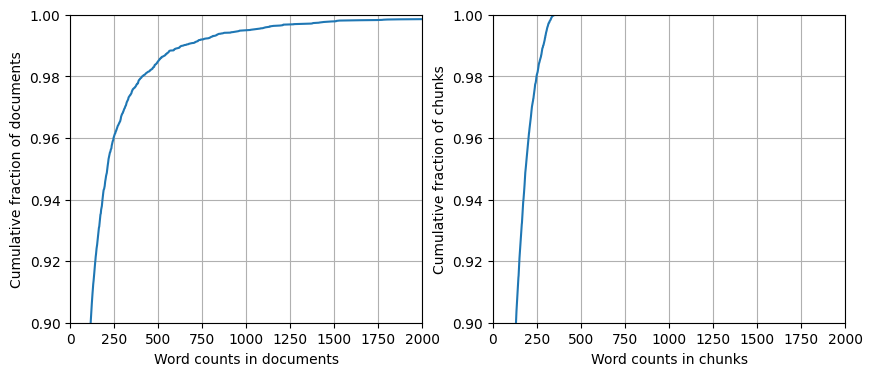

In [112]:
pl.figure(figsize=(10,4))

# Verifying the typical word counts in markdown documents:
cumfrac = pd.Series([len(doc.text.split()) for doc in documents]).value_counts().sort_index().cumsum()
cumfrac = cumfrac / cumfrac.iloc[-1]
# Plot:
pl.subplot(1,2,1)
cumfrac.plot()
pl.ylim([0.9, 1.0])
pl.xlim([0, 2000])
pl.xlabel('Word counts in documents')
pl.ylabel('Cumulative fraction of documents')
pl.grid()

# Verifying the typical word counts in markdown chunks:
cumfrac = pd.Series([len(doc.text.split()) for doc in chunks]).value_counts().sort_index().cumsum()
cumfrac = cumfrac / cumfrac.iloc[-1]
# Plot:
pl.subplot(1,2,2)
cumfrac.plot()
pl.ylim([0.9, 1.0])
pl.xlim([0, 2000])
pl.xlabel('Word counts in chunks')
pl.ylabel('Cumulative fraction of chunks')
pl.grid()

In [8]:
print('We have {:,d} documents and {:,d} chunks'.format(len(documents), len(chunks)))

We have 17,517 documents and 21,707 chunks


### Create and save VectorStore

In [9]:
# Load and embedding model:
#embedding_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", device='cpu')
embedding_model = HuggingFaceEmbedding(model_name="BAAI/bge-m3", device='cpu')
print(embedding_model._model.device)  # see the device that the model is running on

cpu


In [11]:
# Build semantic vector index:
#index = VectorStoreIndex.from_documents(chunks, embed_model=embedding_model)
index = VectorStoreIndex(chunks, embed_model=embedding_model)

In [12]:
# Save the index in the current directory:
index.storage_context.persist(persist_dir="../data/huggingfaceembeddings")

## Perform RAG

### Load data

In [4]:
# Load organization's info:
org_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15_mdlinks.csv')
annot_df = pd.read_csv('../data/processed/w3c-members-country-sector_manual_mdlinks.csv')
annot_df.rename({'hq_country':'country'}, axis=1, inplace=True)

In [5]:
# Load VectorStore:
embedding_model = HuggingFaceEmbedding(model_name="BAAI/bge-m3", device='cpu')
storage_context = StorageContext.from_defaults(persist_dir="../data/huggingfaceembeddings")
index = load_index_from_storage(storage_context, embed_model=embedding_model)

In [6]:
# Load the API key and other parameters:
env = load_env_vars('../keys/openai.txt')
env['OPENAI_PROJECT_ID'] = 'proj_ci0LzudaCPHhM3ouVZZGuD2q'

### Test on Labelled organizations

In [18]:
# Create a client:
client = OpenAI(api_key=env['OPENAI_API_KEY'], project=env['OPENAI_PROJECT_ID'])

In [72]:
df = annot_df

sectors = []
for i in range(len(df)):
    
    # Select organization:
    org = df.iloc[i]
    print(f"[{i}]: {org['name']}:", end=' ')
    # Ask LLM:
    sector = rag_llm_classify(index, org, model='gpt-4.1-nano')
    print(sector)
    # Save result:
    sectors.append(sector)
    

[0]: GLEIF: Nonprofit organization
[1]: Toshiba Corporation: Large enterprise
[2]: Agora.io: Large enterprise
[3]: Quantcast: Large enterprise
[4]: Legible Media Inc.: Small/medium enterprise
[5]: Robert Bosch GmbH: Large enterprise
[6]: VMware: Large enterprise
[7]: NCR Voyix: Large enterprise
[8]: Worldline: Large enterprise
[9]: Janeiro Digital: Small/medium enterprise
[10]: Techfriar: Small/medium enterprise
[11]: The Clearing House: Large enterprise
[12]: Lenovo: Large enterprise
[13]: Centre for Inclusive Design: Nonprofit organization
[14]: Jolocom GmbH: Small/medium enterprise
[15]: Cloudflare: Large enterprise
[16]: TikTok: Large enterprise
[17]: Tigim: Small/medium enterprise
[18]: Brickdoc: Small/medium enterprise
[19]: Wiley: Large enterprise
[20]: Mightybytes: Small/medium enterprise
[21]: Protocol Labs: Technical community
[22]: University of Southampton: Academia
[23]: Koodos Labs: Small/medium enterprise
[24]: Warm Automation: Small/medium enterprise
[25]: mesur.io: Sma

In [73]:
annot_df['llm_sector_3'] = pd.Series(sectors, index=annot_df.index)

In [75]:
annot_results_df = annot_df[['name', 'sector', 'llm_sector']]
#annot_results_df.to_csv('../data/results/w3c-members-country-sector_manual_predictions.csv')
annot_results_df

,name,sector,llm_sector
0,GLEIF,Civil Society,Nonprofit organization
1,Toshiba Corporation,Large Enterprise,Large enterprise
2,Agora.io,Large Enterprise,Large enterprise
3,Quantcast,Large Enterprise,Large enterprise
4,Legible Media Inc.,Small/Medium Enterprise,Small/medium enterprise
5,Robert Bosch GmbH,Large Enterprise,Large enterprise
6,VMware,Large Enterprise,Large enterprise
7,NCR Voyix,Large Enterprise,Large enterprise
8,Worldline,Large Enterprise,Large enterprise
9,Janeiro Digital,Small/Medium Enterprise,Small/Medium Enterprise


### Test on random unknown sample

In [76]:
n_tests = 14
sample_df = org_df.sample(n_tests, random_state=5639837)

In [77]:
df = sample_df

sectors = []
for i in range(len(df)):
    
    # Select organization:
    org = df.iloc[i]
    print(f"[{i}]: {org['name']}:", end=' ')
    # Ask LLM:
    sector = rag_llm_classify(index, org, use_rag=True, model='gpt-4.1-nano')
    print(sector)
    # Save result:
    sectors.append(sector)
    

[0]: 1Password: Small/Medium Enterprise
[1]: Whereby: Small/Medium Enterprise
[2]: Dreamlab Technologies AG: Small/Medium Enterprise
[3]: Agency for Digitisation: Government
[4]: National Institute of Standards and Technology (NIST): Government
[5]: Visa: Large enterprise
[6]: CRITAC: Nonprofit organization
[7]: BSV Association: Nonprofit organization
[8]: NIC.br - Brazilian Network Information Center: Nonprofit organization
[9]: VitalSource Technologies: Large enterprise
[10]: InclusionX 融合加科技: Large enterprise
[11]: Department of Homeland Security: Government
[12]: Book Industry Study Group: Nonprofit organization
[13]: Mattr Limited: Small/Medium Enterprise


In [78]:
sample_df['llm_sector'] = pd.Series(sectors, index=sample_df.index)

In [80]:
sample_df[['name', 'llm_sector']]

,name,llm_sector_2
18,1Password,Small/Medium Enterprise
151,Whereby,Small/Medium Enterprise
182,Dreamlab Technologies AG,Small/Medium Enterprise
55,Agency for Digitisation,Government
298,National Institute of Standards and Technology...,Government
342,Visa,Large enterprise
85,CRITAC,Nonprofit organization
178,BSV Association,Nonprofit organization
15,NIC.br - Brazilian Network Information Center,Nonprofit organization
343,VitalSource Technologies,Large enterprise


In [62]:
#sample_df.to_csv('../data/results/w3c_member-organizations_2025-04-15_predictions.csv')

### Labelling all organizations

In [7]:
# Create a client:
client = OpenAI(api_key=env['OPENAI_API_KEY'], project=env['OPENAI_PROJECT_ID'])

In [8]:
len(org_df)

351

In [12]:
df = org_df

sectors = []
for i in range(len(df)):
    
    # Select organization:
    org = df.iloc[i]
    print(f"[{i}]: {org['name']}:", end=' ')
    # Ask LLM:
    sector = rag_llm_classify(index, org)
    print(sector)
    # Save result:
    sectors.append(sector)   

[0]: Centre For Accessibility Australia: Nonprofit organization
[1]: Intopia: Nonprofit organization
[2]: KurrawongAI: Small/medium enterprise
[3]: Pyx Industries: Nonprofit organization
[4]: Universities Admissions Centre: Nonprofit organization
[5]: Vision Australia: Nonprofit organization
[6]: Danube Tech GmbH: Large enterprise
[7]: Fabasoft: Large enterprise
[8]: WU (Wirschaftsuniversität Wien) - Vienna University of Economics and Business: Academia
[9]: Digitaal Vlaanderen: Government
[10]: GS1: Nonprofit organization
[11]: IAB Europe: Nonprofit organization
[12]: imec: Academia
[13]: ISO 20022 Registration Authority: Nonprofit organization
[14]: VITO: Nonprofit organization
[15]: NIC.br - Brazilian Network Information Center: Nonprofit organization
[16]: Ontotext: Small/Medium Enterprise
[17]: QualiBooth: Small/Medium Enterprise
[18]: 1Password: Small/Medium Enterprise
[19]: Common Approach to Impact Measurement: Technical community
[20]: Crawford Technologies: Large enterprise
[

In [13]:
org_df['llm_sector'] = pd.Series(sectors, index=org_df.index)

In [15]:
# Save results:
#org_df.to_csv('../data/processed/w3c_member-organizations_2025-04-15_llm-sectors.csv', index=False)

### Evaluate the labelling

In [4]:
org_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15_llm-sectors.csv')

In [9]:
n_sample  = 5
sample_df = org_df.sample(n_sample, random_state=587281)

In [10]:
sample_df

,name,website,description,logo,country,country_code,advertising,data,e_commerce,media,network_communications,publishing,smart_cities,web_of_things,filename_prefix,about_link,llm_sector
139,Abra,https://abra.ai,Abra is committed to making mobile apps access...,https://www.w3.org/thumbnails/120/logos/organi...,Netherlands,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abra-ai,https://abra.ai/about,Small/Medium Enterprise
271,Identity.com,https://www.identity.org,NaN,NaN,United States,US,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,www-identity-org,https://www.identity.com/about/,Nonprofit organization
67,Institut National de Recherche en Informatique...,https://www.inria.fr/,Inria is a founding member of W3C. Inria is th...,https://www.w3.org/thumbnails/120/logos/organi...,France,FR,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,www-inria-fr,NaN,Academia
68,Startin'blox,https://startinblox.com/,NaN,NaN,France,FR,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,startinblox-com,NaN,Technical community
166,"Samsung Electronics Co., Ltd.",https://www.samsung.com,Samsung Electronics Co. Ltd. is a global leade...,NaN,South Korea,KR,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,www-samsung-com,https://www.samsung.com/br/about-us/ethics/,Large enterprise


## Testing the system

### Chunking the documents

In [ ]:
# Select chunks from a specific domain:
chunks = sel_chunks_by_domain(documents, 'worldline.com', False)

# Print chunks:
for c in chunks:
    print(bold('[chunk]:'), c.metadata.get('file_name'))
    print(c.get_content())

#### Chunking the chunks

In [ ]:
from collections import defaultdict

# Create dict of lists:
grouped_by_doc = defaultdict(list)

# Group chunks by origin doc:
for node in chunks:
    doc_id = node.ref_doc_id
    grouped_by_doc[doc_id].append(node)

# Get number of chunks per doc:
lengths = dict()
for k in grouped_by_doc.keys():
    lengths[k] = len(grouped_by_doc[k])
n_chunks = pd.Series(lengths)

In [90]:
# Doc IDs with many chunks:
n_chunks.sort_values(ascending=False).head(50).tail(10)

e87c4190-9636-4d62-8e7a-1e5bbbcbf4f9    18
b908eedc-b01d-4e24-bc3d-bc9278e47e8a    17
9d30142a-49d6-4227-9515-3fca4c47e401    17
78ba79bc-f43f-4d56-acd6-27d4d3dbbe39    17
9145b318-8f75-479d-8784-0f81bcab6629    17
07dba9c5-df08-4233-8628-26d5ba9cd9fb    17
d7915d78-5663-4cfe-9dfd-ea50cc50b4df    17
149f3a39-163c-42cc-99dd-d4fc7ccc8a9e    17
0432198b-0de4-45e0-9dc2-188c23e7eaf7    16
03096d4d-2b3f-4320-8130-613e50827718    16
dtype: int64

In [93]:
# Select a list of chunks from the same doc:
l = grouped_by_doc['0432198b-0de4-45e0-9dc2-188c23e7eaf7']

In [104]:
print(l[1].text)

* [ Screen Reader Keyboard Shortcuts ](https://www.skynettechnologies.com/all-one-accessibility-screen-reader-keyboard-shortcuts)

      * [ AccessibilityAssist Pro® ](https://www.skynettechnologies.com/full-website-accessibility-remediation)
      * [ Accessibility Partnership for Agencies ](https://www.skynettechnologies.com/accessibility-for-agencies)
      * [ Accessibility Manual Audit ](https://www.skynettechnologies.com/website-accessibility-audit)
      * [ ADA Web Accessibility Remediation ](https://www.skynettechnologies.com/ada-website-accessibility)
      * [ Accessibility Web Design ](https://www.skynettechnologies.com/ada-compliant-website-design)
      * [ Accessibility Web Development ](https://www.skynettechnologies.com/accessibility-web-development)
      * [ VPAT/Accessibility Conformance Report ](https://www.skynettechnologies.com/vpat-accessibility-conformance-report)
      * [ Accessible Document Remediation ](https://www.skynettechnologies.com/accessible-document

In [96]:
print(l[2].text)

Checker ](https://www.skynettechnologies.com/color-contrast-checker)
      * [ Color Blindness Simulator ](https://www.skynettechnologies.com/color-blindness-simulator)
      * [ Web Accessibility Standards ](https://www.skynettechnologies.com/accessibility-standards)
      * [ Accessibility Statement Generator ](https://www.skynettechnologies.com/accessibility-statement-generator)
      * [ Accessibility Tax Credit Calculator ](https://www.skynettechnologies.com/tax-credit-calculator)
      * [ Free Accessibility Pricing Calculator ](https://www.skynettechnologies.com/free-accessibility-pricing-calculator)
      * [ Digital Accessibility Starter Kit ](https://www.skynettechnologies.com/resources/digital-accessibility-starter-kit)
      * [ Free Accessibility Checker ](https://www.skynettechnologies.com/accessibility-checker)
      * [ Accessibility Scanning Monitoring ](https://www.skynettechnologies.com/accessibility-scanning-and-monitoring)

    * [ IMAGE  CMS  Manage your content w

### Semantic search

In [32]:
te = embedding_model.get_text_embedding('We are Threfers. Our company is based in the USA and manufactures electric cars.')
qe = embedding_model.get_query_embedding('Organizations with expertise in environment-friendly products')
tq = embedding_model.get_text_embedding('Organizations with expertise in environment-friendly products')
qe = embedding_model.get_query_embedding('Threfers')
tq = embedding_model.get_text_embedding('Threfers')

In [34]:
# Compute the cosine similarity:
embedding_model.similarity(te, qe)

0.6064789971460802

In [33]:
# Compute the cosine similarity:
embedding_model.similarity(te, tq)

0.6236900029863514

### Check chunks in index

In [130]:
index.docstore.docs['cd2d5744-0028-4bba-901e-7c7d909f54be']

TextNode(id_='cd2d5744-0028-4bba-901e-7c7d909f54be', embedding=None, metadata={'file_path': '/home/hxavier/ceweb/projetos/w3c_members/analises/../data/processed/org_websites/centreforinclusivedesign-org-au_nolinks_2025-06-30.md', 'file_name': 'centreforinclusivedesign-org-au_nolinks_2025-06-30.md', 'file_type': 'text/markdown', 'file_size': 4379, 'creation_date': '2025-06-30', 'last_modified_date': '2025-06-30', 'domain': 'centreforinclusivedesign.org.au', 'mdtype': 'nolinks', 'date': '2025-06-30'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e114cbb2-1b26-4351-93bd-647dc8e9e2e7', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/home/hxavier/ceweb/projetos/w3c_members/analises/../data/proc

### Retrieving chunks

In [183]:
chunks = retriever.retrieve('Return the link to a page about the organization')

print('Found {} chunks.'.format(len(chunks)))

Found 2 chunks.


In [184]:
print(chunks[1].get_content())

com/en-ch/home)
    * [ Switzerland  French  ](https://worldline.com/fr-ch/home)
    * [ Switzerland  German  ](https://worldline.com/de-ch/home)
    * [ Switzerland  Italian  ](https://worldline.com/it-ch/home)
    * [ Türkiye  Turkish  ](https://worldline.com/tr-tr/home)
    * [ United Kingdom  English  ](https://worldline.com/en-gb/home)
    * [ United States of America  English  ](https://worldline.com/en-us/home)

  * [ Partners ](https://worldline.com/en/home/top-navigation/partners)
  * [ Careers  Opens in a new tab  ](https://jobs.worldline.com)
  * [ Developers  Opens in a new tab  ](https://developer.worldline.com/en/home)
  * [ Investors  Opens in a new tab  ](https://investors.worldline.com)

  * About Worldline 

About Worldline

    * [ Who we are  ](https://worldline.com/en/home/top-navigation/about-worldline/who-we-are)
    * [ CSR  ](https://worldline.com/en/home/main-navigation/knowledge/themes/csr)
    * [ Executive Committee  ](https://worldline.com/en/home/top-navi

## Using the API

In [ ]:
client.chat.completions.create()

In [40]:
completion = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {
            "role": "user",
            "content": "Write a one-sentence joke about a unicorn."
        }
    ]
)

In [41]:
completion.choices[0].message.content

'Why did the unicorn refuse to pay for the haircut? Because it preferred a "mane" event!'

In [ ]:
sector_classify_template = """

"""

# Trash

## Embedding search

In [26]:
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

## Find documents in Portuguese

In [234]:
def is_ptbr(text):
    #accents = re.search('[áàãâéêíóôõúüç]', text, flags=re.IGNORECASE)
    accents = re.search('Ã©|Ãª|Ã§|Ã£|Ãµ|Ã­|Ã³', text)
    return accents
    if accents != None:
        return True
    else:
        return False

In [240]:
websites = glob('../data/processed/org_websites/abouts/*.md')
text = read_text(websites[0])

In [241]:
lang_dict = dict()
for w in websites:
    text = read_text(w)
    prefix = w.split('/')[-1].split('_')[0]
    lang_dict[prefix] = is_ptbr(text)
lang = pd.Series(lang_dict) 

In [237]:
prefix2domain_df.loc[prefix2domain_df['website'].str.contains('.jp$')]

,filename_prefix,website
104,ebpaj-jp,http://ebpaj.jp
107,www-ftl-co-jp,http://www.ftl.co.jp
109,www-internetacademy-jp,https://www.internetacademy.jp
133,www-voyager-co-jp,https://www.voyager.co.jp


In [242]:
messed_up = lang.loc[~lang.isnull()].index

In [265]:
reload = pd.concat([org_df[['name', 'filename_prefix', 'website', 'about_link']], annot_df[['name', 'filename_prefix', 'website', 'about_link']]], ignore_index=True)

In [256]:
chines = ['www-360-cn', 'www-buaa-edu-cn', 'www-caict-ac-cn', 'www-cesi-cn', 'www-cas-cn', 'www-dappworks-cn', 'inclusionx-cn', 'tpblock-cn', 'www-loongson-cn', 'www-memect-cn', 'www-nju-edu-cn', 'www-siaa-org-cn', 'www-sziit-edu-cn', 'www-zju-edu-cn', 'www-ziiot-org-cn', 'www-ftl-co-jp', 'www-voyager-co-jp']
port = ['www-intel-com','www-lge-com', 'www-monotype-com', 'www-nvidia-com', 'www-paypal-com', 'www-salesforce-com','www-samsung-com']
port2 = ['dfinity-org', 'www-capitalone-com', 'www-cgi-br', 'discord-com', 'www-buaa-edu-cn', 'global-rakuten-com', 'www-igalia-com', 'www-kevel-com', 'www-pingidentity-com']
tot = chines + port + port2

In [255]:
print(list(prefix2domain_df.loc[prefix2domain_df['filename_prefix'].str.contains('.cn$'), 'filename_prefix']))

['www-360-cn', 'www-buaa-edu-cn', 'www-caict-ac-cn', 'www-cesi-cn', 'www-cas-cn', 'www-dappworks-cn', 'inclusionx-cn', 'tpblock-cn', 'www-loongson-cn', 'www-memect-cn', 'www-nju-edu-cn', 'www-siaa-org-cn', 'www-sziit-edu-cn', 'www-zju-edu-cn', 'www-ziiot-org-cn']


15                              http://www.cgi.br/about/
27                    http://www.360.cn/about/index.html
44                      https://tpblock.cn/about-us.html
46                         http://www.memect.cn/aboutus/
49                       http://www.siaa.org.cn/about-us
126               https://global.rakuten.com/corp/about/
133                     https://www.voyager.co.jp/about/
166          https://www.samsung.com/br/about-us/ethics/
170                         https://www.igalia.com/about
181                            https://dfinity.org/about
237                    https://www.capitalone.com/about/
256                          https://discord.com/careers
280                          https://www.kevel.com/about
303           https://www.nvidia.com/en-us/about-nvidia/
312          https://www.paypal.com/br/webapps/mpp/about
313    https://www.pingidentity.com/en/company/about-...
Name: about_link, dtype: object

In [247]:
#captures = prefix2domain_df.loc[prefix2domain_df['filename_prefix'].isin(messed_up), 'website']
captures = prefix2domain_df.loc[prefix2domain_df['filename_prefix'].str.contains('.cn$'), 'website']
captures = ['http://www.ftl.co.jp', 'https://www.voyager.co.jp']
captures = prefix2domain_df.loc[prefix2domain_df['filename_prefix'].isin(['www-intel-com','www-lge-com', 'www-monotype-com', 'www-nvidia-com', 'www-paypal-com', 'www-salesforce-com','www-samsung-com']), 'website']

In [266]:
abouts = reload.loc[reload['filename_prefix'].isin(tot)].dropna(subset='about_link')

In [268]:
# Change to True if you want to collect new data:
if True:
    
    data_folder = '../data/processed/org_websites/abouts/'
    for i in range(0, len(abouts)):
        
        # Select organization:
        org = abouts.iloc[i]
        print(f"{i}: {org['name']} ({org['about_link']})", end=' ')

        if org['about_link'] != None:
            try:
                # Get webpage:
                soup = get_web_content(org['about_link'])
                
                # Save markdown without links: 
                markdown_clean = soup2markdown(soup, True)
                filename_clean = make_filename(org['website'], True)
                save_text(data_folder, filename_clean, markdown_clean)
        
                # Skip line
                print('')
        
            except requests.exceptions.ConnectionError as e:
                print(bold('FAILED:'), e)
        else:
            print('NO ABOUT LINK.')

0: NIC.br - Brazilian Network Information Center (http://www.cgi.br/about/) 
1: 360 (http://www.360.cn/about/index.html) 
2: Jiangsu TPBlock Technology Co., Ltd. （江苏第三极区块链科技有限公司） (https://tpblock.cn/about-us.html) 

/home/hxavier/system/envs/openai/lib/python3.8/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tpblock.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



3: Memect Technology Co. Ltd. 北京文因互联科技有限公司 (http://www.memect.cn/aboutus/) 
4: Shenzhen Accessibility Research Association (http://www.siaa.org.cn/about-us) 

/home/hxavier/system/envs/openai/lib/python3.8/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.siaa.org.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



5: Rakuten Group, Inc. (https://global.rakuten.com/corp/about/) 
6: Voyager Japan, Inc. (https://www.voyager.co.jp/about/) 
7: Samsung Electronics Co., Ltd. (https://www.samsung.com/br/about-us/ethics/) 
8: Igalia (https://www.igalia.com/about) 
9: Dfinity Stiftung (https://dfinity.org/about) 
10: Capital One Financial (https://www.capitalone.com/about/) 
11: Discord (https://discord.com/careers) 
12: Kevel (https://www.kevel.com/about) 
13: NVIDIA (https://www.nvidia.com/en-us/about-nvidia/) 
14: PayPal (https://www.paypal.com/br/webapps/mpp/about) 
15: Ping Identity (https://www.pingidentity.com/en/company/about-us.html) 


In [271]:
for a in abouts['filename_prefix']:
    print (f'rm -f {a}_nolinks_2025-07-11.md')

rm -f www-cgi-br_nolinks_2025-07-11.md
rm -f www-360-cn_nolinks_2025-07-11.md
rm -f tpblock-cn_nolinks_2025-07-11.md
rm -f www-memect-cn_nolinks_2025-07-11.md
rm -f www-siaa-org-cn_nolinks_2025-07-11.md
rm -f global-rakuten-com_nolinks_2025-07-11.md
rm -f www-voyager-co-jp_nolinks_2025-07-11.md
rm -f www-samsung-com_nolinks_2025-07-11.md
rm -f www-igalia-com_nolinks_2025-07-11.md
rm -f dfinity-org_nolinks_2025-07-11.md
rm -f www-capitalone-com_nolinks_2025-07-11.md
rm -f discord-com_nolinks_2025-07-11.md
rm -f www-kevel-com_nolinks_2025-07-11.md
rm -f www-nvidia-com_nolinks_2025-07-11.md
rm -f www-paypal-com_nolinks_2025-07-11.md
rm -f www-pingidentity-com_nolinks_2025-07-11.md


In [248]:
data_folder = '../data/processed/org_websites/'
for c in captures:
    print(c)
    
    # Get webpage:
    soup = get_web_content(c)
    
    # Save markdown with links:
    markdown_links = soup2markdown(soup, False)
    filename_links = make_filename(c, False)
    save_text(data_folder, filename_links, markdown_links)
    
    # Save markdown without links: 
    markdown_clean = soup2markdown(soup, True)
    filename_clean = make_filename(c, True)
    save_text(data_folder, filename_clean, markdown_clean)

    # Skip line
    print('')


http://www.lge.com

https://www.samsung.com

http://www.intel.com/

http://www.monotype.com/

https://www.nvidia.com

https://www.paypal.com

https://www.salesforce.com/



In [209]:
for m in messed_up:
    print(f'rm -f {m}*')

rm -f dfinity-org*
rm -f www-capitalone-com*
rm -f www-cgi-br*
rm -f discord-com*
rm -f www-buaa-edu-cn*
rm -f global-rakuten-com*
rm -f www-igalia-com*
rm -f www-kevel-com*
rm -f www-pingidentity-com*


## Clusterização e eliminação de redundâncias no conteúdo recuperado

In [187]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [188]:
# Embed results in LLM vectorial space:
results_embed = [embedding_model.get_text_embedding(text) for text in results['text']]
X = np.array(results_embed)

# Build clustering pipeline:
svd = TruncatedSVD(n_components=10)
kmeans = KMeans(n_clusters=3, n_init='auto')
pipe = Pipeline([('svd', svd), ('kmeans', kmeans)])

# Cluster results
cluster = pipe.fit_predict(X)

cl_df = results.copy()
cl_df['cluster'] = pd.Series(cluster, index=cl_df.index)
